# Hopfield モデル


{cite:p}`Hopfield1982-vu`で提案．始めは1と0の状態を取った．

Hopfieldモデルと呼ばれることが多いが，Amariの先駆的研究{cite:p}`Amari1972-fq`を踏まえAmari-Hopfieldモデルと呼ばれることもある．

次のような連続時間線形モデルを考える．シナプス前活動を$\mathbf{x}\in \mathbb{R}^n$, 後活動を$\mathbf{y}\in \mathbb{R}^m$, 重み行列を$\mathbf{W}\in \mathbb{R}^{m\times n}$とする．

$$
\frac{d\mathbf{y}}{dt}=-\mathbf{y}+\mathbf{W}\mathbf{x}+\mathbf{b}
$$

ここで$\dfrac{\partial\mathcal{L}}{\partial\mathbf{y}}:=-\dfrac{d\mathbf{y}}{dt}$となるような$\mathcal{L}\in \mathbb{R}$を仮定すると，

$$
\mathcal{L}=\int \left(\mathbf{y}-\mathbf{W}\mathbf{x}-\mathbf{b}\right)\ d\mathbf{y}=\frac{1}{2}\|\mathbf{y}\|^2-\mathbf{y}^\top \mathbf{W}\mathbf{x}-\mathbf{y}^\top \mathbf{b}
$$

となる． これをさらに$\mathbf{W}$で微分すると，

$$
\dfrac{\partial\mathcal{L}}{\partial\mathbf{W}}=-\mathbf{y}\mathbf{x}^\top\Rightarrow
\frac{d\mathbf{W}}{dt}=-\dfrac{\partial\mathcal{L}}{\partial\mathbf{W}}=\mathbf{y}\mathbf{x}^\top=(\text{post})\cdot (\text{pre})^\top
$$

となり，Hebb則が導出できる．

## モデルの定義

In [1]:
using Base: @kwdef
using Parameters: @unpack
using LinearAlgebra, PyPlot, Random, Distributions, Statistics, ImageTransformations, TestImages, ColorTypes

In [2]:
@kwdef mutable struct AmariHopfieldModel
    W::Array  # weights
    θ::Vector # thresholds
end

# Training weights & definition of model
function AmariHopfieldModel(inputs; σθ=1e-2)
    num_data, num_units = size(inputs) # inputs : num_data x num_unit
    inputs = mapslices(x -> x .- mean(x), inputs, dims=2)  
    W = (inputs' * inputs) / num_data # hebbian rule
    W -= diagm(diag(W))               # Set the diagonal of weights to zero
    return AmariHopfieldModel(W=W, θ=σθ*randn(num_units))
end;

In [3]:
binarize(img) = 2.0((img .- mean(img)) .> 0) .- 1; # img to {-1, 1}

function corrupted(img, p=0.3)
    mask = rand(Binomial(1, p), size(img));
    return img .* (1 .- mask) - img .* mask; 
end

corrupted (generic function with 2 methods)

## データセットの作成

In [4]:
testimagelist = ["cameraman", "jetplane", "house", "mandril_gray", "lake_gray"]; # gray & size(512 x 512)
num_data = length(testimagelist)

imgs = [convert(Array{Float64}, imresize(Gray.(testimage(imagename)), ratio=1/8)) for imagename in testimagelist];
imgs_binarized = map(binarize, imgs);
imgs_corrupted = map(corrupted, imgs_binarized);

input_train = reshape(cat(imgs_binarized..., dims=3), (:, num_data))';
input_test = reshape(cat(imgs_corrupted..., dims=3), (:, num_data))';

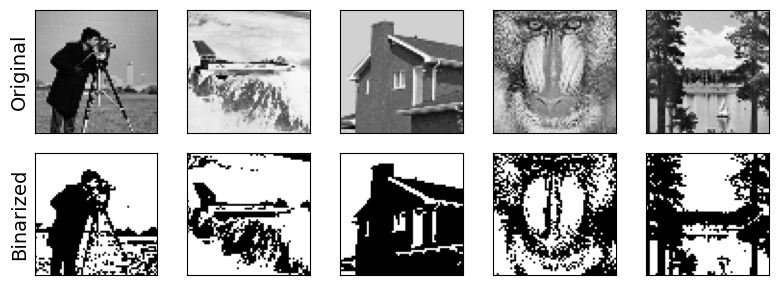

In [5]:
figure(figsize=(8, 3))
for i in 1:num_data
    subplot(2, num_data, i); imshow(imgs[i], cmap="gray"); 
    xticks([]); yticks([]); if i==1 ylabel("Original", fontsize=14) end;
    subplot(2, num_data, i+num_data); imshow(imgs_binarized[i], cmap="gray"); 
    xticks([]); yticks([]); if i==1 ylabel("Binarized", fontsize=14) end;
end
tight_layout()

## モデルの定義と訓練

In [6]:
model = AmariHopfieldModel(input_train);

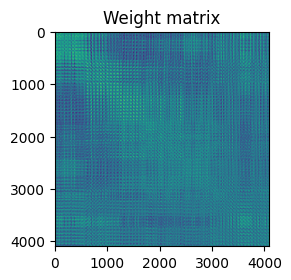

In [7]:
figure(figsize=(3, 3))
title("Weight matrix"); imshow(model.W); 
tight_layout()

## 画像の復元

エネルギー関数

$$
E=-{\frac 12}\sum _{{i,j}}{w_{{ij}}{s_{i}}{s_{j}}}+\sum _{i}{\theta _{i}}{s_{i}}=-{\frac 12}\mathbf{s}^\top\mathbf{W}\mathbf{s}+\mathbf{\theta}^\top\mathbf{s}
$$

を最小化するように内部状態 $\mathbf{s}$ を更新．

$$
\mathbf{s}\leftarrow \text{sign}\left(\mathbf{W}\mathbf{s}-\mathbf{\theta}\right)
$$

In [8]:
energy(W, s, θ) = -0.5s' * W * s + θ' * s

# Synchronous update
function prediction(model::AmariHopfieldModel, init_s, max_iter=100)
    @unpack W, θ = model
    s, e = init_s, energy(W, init_s, θ)
    for t in 1:max_iter
        s = sign.(W * s - θ)    # update s
        e_tp1 = energy(W, s, θ) # compute state (t+1) energy
        if abs(e_tp1-e) < 1e-3   # convergence
            return s
        end
    end
    return s
end;

In [9]:
imgs_predicted = [reshape(prediction(model, input_test[i, :]), (64, 64)) for i in 1:num_data];

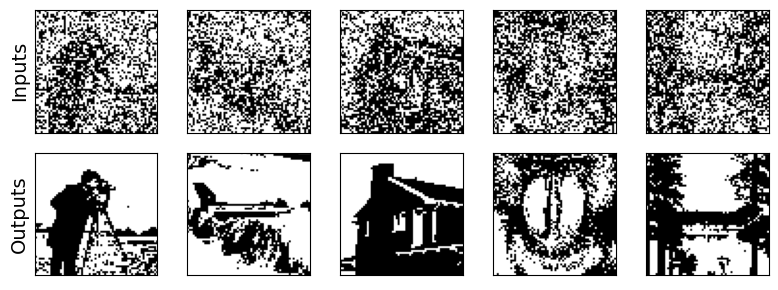

In [10]:
figure(figsize=(8, 3))
for i in 1:num_data
    subplot(2, num_data, i); imshow(imgs_corrupted[i], cmap="gray");  
    xticks([]); yticks([]); if i==1 ylabel("Inputs", fontsize=14) end;
    subplot(2, num_data, i+num_data); imshow(imgs_predicted[i], cmap="gray");  
    xticks([]); yticks([]); if i==1 ylabel("Outputs", fontsize=14) end;
end
tight_layout()

## 稠密連想記憶 (dense associative memory) モデル

**Dense Associative Memory (DAM)**モデル（Modern Hopfield networksとも呼ばれる）．

- Krotov, Dmitry, and John J. Hopfield. 2016. “Dense Associative Memory for Pattern Recognition.” arXiv [cs.NE]. arXiv. http://arxiv.org/abs/1606.01164.
- Krotov, Dmitry, and John Hopfield. 2018. “Dense Associative Memory Is Robust to Adversarial Inputs.” Neural Computation 30 (12): 3151–67.
- Krotov, Dmitry, and John J. Hopfield. 2019. “Unsupervised Learning by Competing Hidden Units.” Proceedings of the National Academy of Sciences of the United States of America 116 (16): 7723–31.


- Ramsauer, Hubert, Bernhard Schäfl, Johannes Lehner, Philipp Seidl, Michael Widrich, Thomas Adler, Lukas Gruber, et al. 2020. “Hopfield Networks Is All You Need.” arXiv [cs.NE]. arXiv. http://arxiv.org/abs/2008.02217.

深層ニューラルネットワークへの応用．


- Krotov, Dmitry, and John J. Hopfield. 2020. “Large Associative Memory Problem in Neurobiology and Machine Learning.” Https://openreview.net › Forumhttps://openreview.net › Forum. https://openreview.net/pdf?id=X4y_10OX-hX.

“Hopfield Networks Is All You Need.”の論文における非生理学的3ニューロン相互作用の緩和．

## 参考文献
```{bibliography}
:filter: docname in docnames
```